<a href="https://colab.research.google.com/github/ShimminS096/material_computer_cross/blob/minseo/dnn_keras_0529.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Hyperparameter Setting**


*   Learning_Rate : 0.001
*   Normoralization : x - 전체 데이터의 mean값 / 전체 데이터의 std값
*   Dataset_Structure : train_dataset(64%)|vaildation_dataset(16%)|test_dataset(20%)
*   Train_Batch_Size : 128
*   Test_Batch_Size : NULL(없음)
*   Random_State : 24
*   Epoch : 1000
*   DNN Activation_Function : relu
*   Metrics : mse, mae
*   Loss_Function : mse
*   Optimizer : RMSDprop
*   Dataset_Filename : Filtered_Dataset.npz
*   Label_Filename : Ground Truth.csv
*   Input_Size : 301
*   Hidden_Size : [100, 100, 50]









# 1. Data loading & Dataset setting



  1-1. Load dataset

In [60]:
import numpy as np
import pathlib
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import layers
from datetime import datetime
print(tf.__version__)

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.metrics import Accuracy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# For saving hyperparameter of model
from google.colab import drive
drive.mount('/content/drive')

# Google Drive folder dir
folder_path = '/content/drive/My Drive/DNN_Hyperparameter'  # 'your_folder_name'을 실제 폴더 이름으로 바꾸세요

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Making hyperparameter & result data
def save_data_to_file(data, folder_path):
    # filename -> timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S_%f')
    file_name = f'data_{timestamp}.txt'
    file_path = os.path.join(folder_path, file_name)

    # txt 파일로 데이터 저장
    with open(file_path, 'w') as file:
        file.write(data)

    print(f"Data has been saved to {file_path}")

def save_plot_to_file(plot_figure, folder_path):
    # 현재 시간으로 파일 이름 생성
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    file_name = f'plot_{timestamp}.png'
    file_path = os.path.join(folder_path, file_name)

    plot_figure.savefig(file_path)
    print(f"Plot has been saved to {file_path}")

#------------------------------------------------------------------------

# Load dataset
# Convert array type : Numpy -> Pandas(DataFrame)
# Delete unused columns from array
dataset_column_names = [str(i) for i in range(301)]
label_column_names = ['index', 'Data_Num', 'Vth', 'Mobility', 'S-Slope', 'On/Off']
uploaded_dataset_label_path = 'Ground Truth.csv'
dataset = np.load('Filtered_Dataset.npz')['dataset']
dataset = pd.DataFrame(dataset)
label_dataset = pd.read_csv(uploaded_dataset_label_path, names = label_column_names,
                          na_values="?", comment='\t', skipinitialspace=True)
label_dataset.drop('Data_Num', axis=1, inplace=True)
label_dataset.drop('index', axis=1, inplace=True)


2.15.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Hyperparameter

In [46]:

# Setting
EPOCHS = 1000
BATCH_SIZE = 128
SELECTED_LABEL = 'On/Off'
RANDOMSTATE = 24
LEARNING_RATE = 0.001
ACTIVATION_FUNCTION = 'relu'



1-2. Setting input data

In [47]:

# Make One-hot Vector label data
# Split WANTED label column from label_dataset(Vth, Mobility, SS, On/Off)
label = label_dataset[SELECTED_LABEL].copy()
label = label.drop(0)
label = label.reset_index(drop=True)
label = label.astype(float)



# Make dataset used for model [ measured feature (idx:0~300) | mobility (idx:301)]
dataset = pd.concat([dataset, label], axis=1)
train_dataset = dataset.sample(frac=0.8,random_state=RANDOMSTATE)
test_dataset = dataset.drop(train_dataset.index)


1-3. Visualize input data

,count,mean,std,min,25%,50%,75%,max
0,319.0,6.830831e-10,1.194990e-08,8.000000e-12,1.200000e-11,1.330000e-11,1.500000e-11,2.134460e-07
1,319.0,5.117618e-11,6.982215e-10,6.400000e-12,1.020000e-11,1.180000e-11,1.325000e-11,1.248260e-08
2,319.0,1.351411e-11,4.408241e-11,5.400000e-12,9.200000e-12,1.070000e-11,1.230000e-11,7.967000e-10
3,319.0,1.038056e-11,3.316549e-12,4.100000e-12,8.500000e-12,9.900000e-12,1.140000e-11,3.140000e-11
4,319.0,9.866771e-12,2.963408e-12,4.400000e-12,8.000000e-12,9.500000e-12,1.110000e-11,2.590000e-11
...,...,...,...,...,...,...,...,...
296,319.0,3.536472e-03,3.862668e-04,2.371390e-03,3.223610e-03,3.548210e-03,3.843910e-03,4.640530e-03
297,319.0,3.572408e-03,3.897917e-04,2.396420e-03,3.256420e-03,3.585260e-03,3.883210e-03,4.685200e-03
298,319.0,3.608347e-03,3.934946e-04,2.417710e-03,3.289355e-03,3.622060e-03,3.922505e-03,4.729130e-03
299,319.0,3.644465e-03,3.970520e-04,2.443580e-03,3.322395e-03,3.658880e-03,3.962140e-03,4.773160e-03


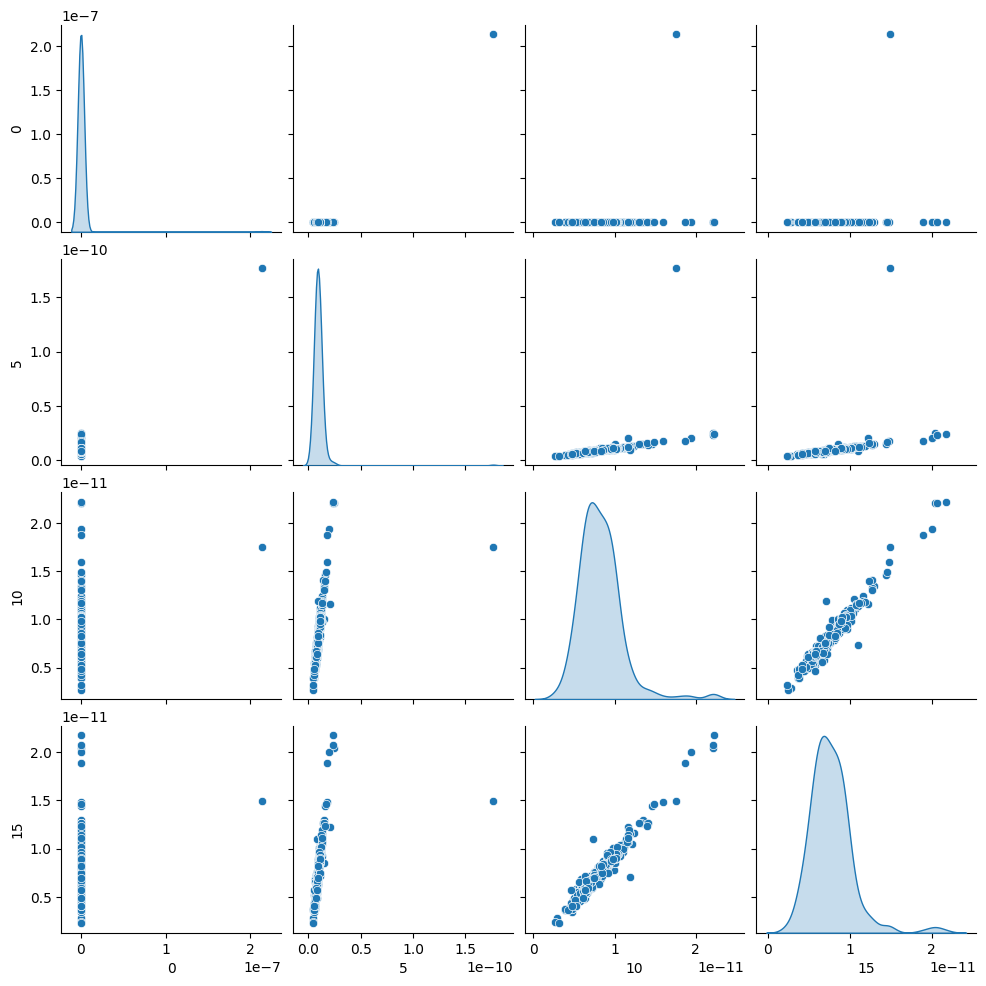

In [48]:

# VIsualize train_dataset
sns.pairplot(train_dataset[[0, 5, 10, 15]], diag_kind="kde")

# Statistic feature of train_dataset
train_stats = train_dataset.describe()
train_stats.pop(SELECTED_LABEL)
train_stats = train_stats.transpose()
train_stats


1-4. Split train data, train data's label, test data, test data's label

In [49]:

# Detach 'Mobility' column from train_dataset & test_dataset
train_labels = train_dataset.pop(SELECTED_LABEL)
test_labels = test_dataset.pop(SELECTED_LABEL)

# Data Normalization - standardization
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

#normed_train_data = norm(train_dataset)
#normed_test_data = norm(test_dataset)

#--------------------------------------

# Data Normalization - log10 transform
def norm_log10(x):
  return (np.log10(x + 1))

train_labels = norm_log10(train_labels)
test_labels = norm_log10(test_labels)

normed_train_data = norm_log10(train_dataset)
normed_test_data = norm_log10(test_dataset)





---



# 2. Construct DNN structure

In [50]:

def build_model():
  model = keras.Sequential([
    layers.Dense(100, activation=ACTIVATION_FUNCTION, input_shape=[len(train_dataset.keys())]),
    layers.Dense(100, activation=ACTIVATION_FUNCTION),
    layers.Dense(50, activation=ACTIVATION_FUNCTION),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 100)               30200     
                                                                 
 dense_25 (Dense)            (None, 100)               10100     
                                                                 
 dense_26 (Dense)            (None, 50)                5050      
                                                                 
 dense_27 (Dense)            (None, 1)                 51        
                                                                 
Total params: 45401 (177.35 KB)
Trainable params: 45401 (177.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________




---



# 3. train

In [51]:

# While each epoch ended, print dot(.) to visualize train process
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

# Training
history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0, batch_size = BATCH_SIZE,
  callbacks=[PrintDot()])



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

 3-1. Visualize model training process

In [52]:

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,0.049111,0.161132,0.049111,0.033859,0.132399,0.033859,995
996,0.049191,0.161332,0.049191,0.033917,0.132507,0.033917,996
997,0.049216,0.161612,0.049216,0.033533,0.132028,0.033533,997
998,0.049154,0.162125,0.049154,0.033433,0.131918,0.033433,998
999,0.049177,0.161873,0.049177,0.033707,0.132209,0.033707,999


3-2. Training without EarlyStopping callback

Plot has been saved to /content/drive/My Drive/DNN_Hyperparameter/plot_20240529_052209.png


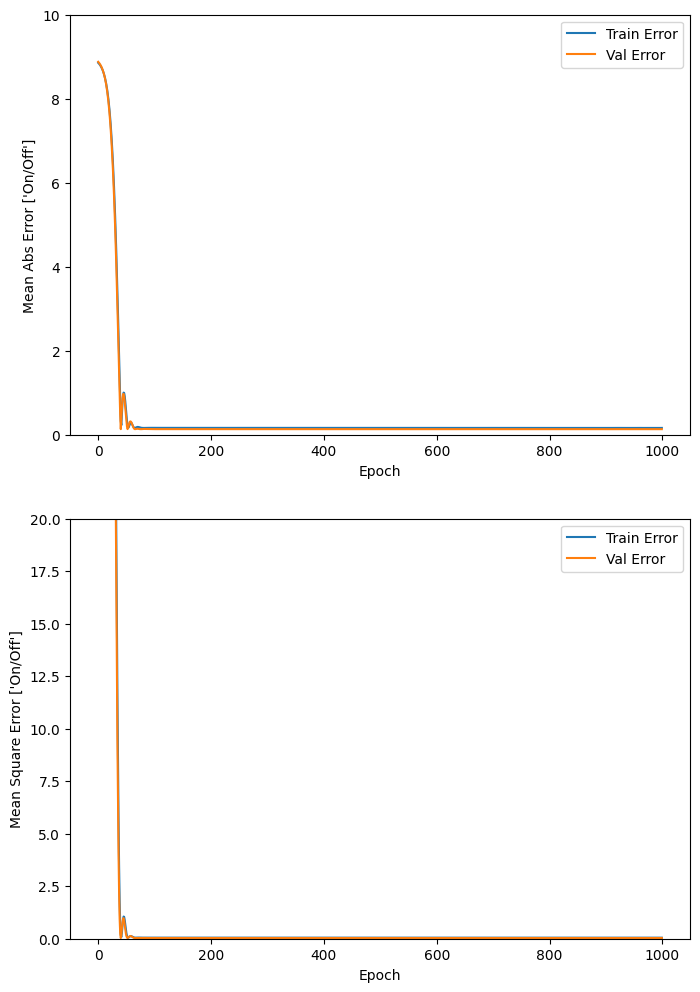

In [53]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel(f"Mean Abs Error ['{SELECTED_LABEL}']")
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,10])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel(f"Mean Square Error ['{SELECTED_LABEL}']")
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()


  #시각자료 저장
  plot_figure = plt.gcf()
  save_plot_to_file(plot_figure,folder_path)

  plt.show()

plot_history(history)


3-3. Train with EarlyStopping callback


....................................................................................................
.........................................................................Plot has been saved to /content/drive/My Drive/DNN_Hyperparameter/plot_20240529_052221.png


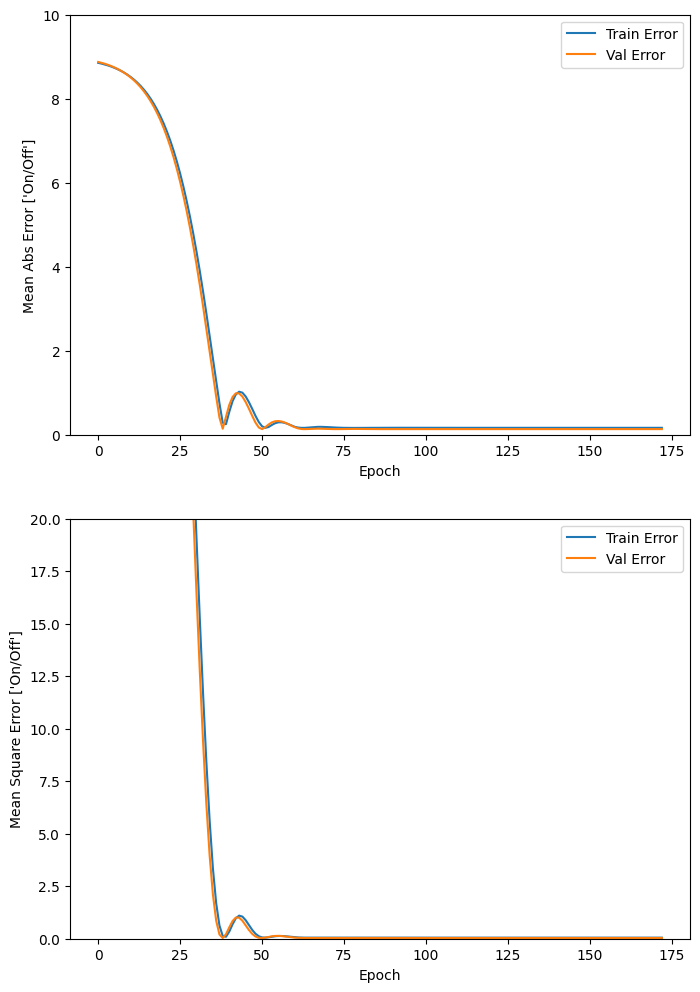

In [54]:
model = build_model()

# patience parameter is a epoch size for checking performance improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

# train
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, batch_size = 128,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)



---



# 5. Test

In [55]:

# For model evaluation, change Pandas(DataFrame) to Numpy with float type
normed_test_data_array = normed_test_data.to_numpy().astype(float)

# Test
loss, mae, mse = model.evaluate(normed_test_data_array, test_labels, verbose=24)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))


테스트 세트의 평균 절대 오차:  0.20 MPG


5-1. Visualize Prediction (with test data)

3/3 [==============================] - 0s 6ms/step
[6.5294208e+08 5.7424486e+08 6.8157139e+08 6.4632442e+08 6.1812960e+08]
Plot has been saved to /content/drive/My Drive/DNN_Hyperparameter/plot_20240529_052223.png


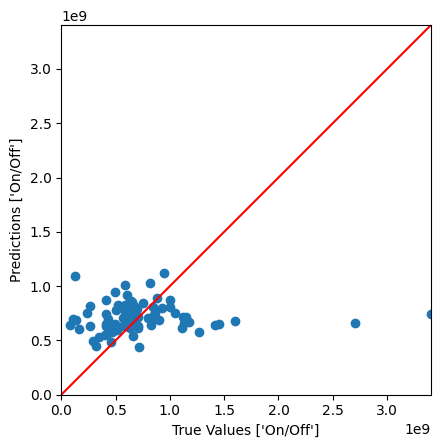

In [56]:

test_predictions = model.predict(normed_test_data).flatten()

# 로그를 다시 원래 값으로 되돌리기
test_labels = np.power(10, test_labels) - 1
test_predictions = np.power(10, test_predictions) - 1

print(test_predictions[0:5])

# 산포도 그리기
plt.scatter(test_labels, test_predictions)
plt.xlabel(f"True Values ['{SELECTED_LABEL}']")
plt.ylabel(f"Predictions ['{SELECTED_LABEL}']")
plt.axis('equal')
plt.axis('square')

# xlim과 ylim 설정
max_value = max(np.max(test_labels), np.max(test_predictions))
plt.xlim([0, max_value])
plt.ylim([0, max_value])

# 대각선 1:1 라인 그리기
_ = plt.plot([0, max_value], [0, max_value], color='red')


#시각자료 저장
plot_figure = plt.gcf()
save_plot_to_file(plot_figure,folder_path)


# 그래프 보여주기
plt.show()


Plot has been saved to /content/drive/My Drive/DNN_Hyperparameter/plot_20240529_052223.png


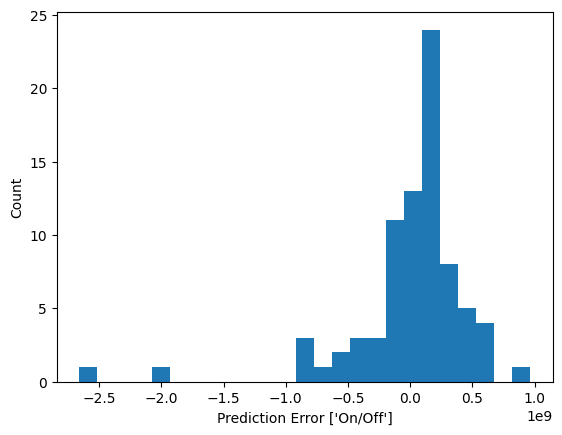

In [57]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel(f"Prediction Error ['{SELECTED_LABEL}']")
_ = plt.ylabel("Count")

#시각자료 저장
plot_figure = plt.gcf()
save_plot_to_file(plot_figure,folder_path)

In [58]:
# 정확도
test_labels = norm_log10(test_labels)
test_predictions = norm_log10(test_predictions)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(test_labels, test_predictions)
print(f'Mean Absolute Error (MAE): {mae:.2f}')

# Mean Squared Error (MSE)
mse = mean_squared_error(test_labels, test_predictions)
print(f'Mean Squared Error (MSE): {mse:.2f}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

# R² Score
r2 = r2_score(test_labels, test_predictions)
print(f'R² Score: {r2:.2f}')

Mean Absolute Error (MAE): 0.20
Mean Squared Error (MSE): 0.08
Root Mean Squared Error (RMSE): 0.28
R² Score: -0.10


Saving data

In [61]:
# 예시 데이터
formatted_data = f" activation function = '{ACTIVATION_FUNCTION}'\n epcohs = '{EPOCHS}'\ batch size = '{BATCH_SIZE}'\n lr = '{LEARNING_RATE}'\n selected label = '{SELECTED_LABEL}\n random state = '{RANDOMSTATE}'\n"
loss_data = f" mae loss : '{mae}\n mse loss : '{mse}'\n rmse loss : '{rmse}'\n r2 score loss : '{r2}'\n"

# 새로운 파일로 데이터 저장
save_data_to_file(formatted_data, folder_path)
save_data_to_file(loss_data, folder_path)


Data has been saved to /content/drive/My Drive/DNN_Hyperparameter/data_20240529_052606_921763.txt
Data has been saved to /content/drive/My Drive/DNN_Hyperparameter/data_20240529_052606_932701.txt
